OsmoFlux notebook

This notebook contains multiple electrical/hydraulic abstractions of a Reverse Electrodialysis (RED) stack. All of them share the same high-level physical ingredients:
	•	A salinity gradient produces an electromotive force (EMF / “OCV”) via Nernst-type relations.
	•	Current flowing through the stack causes (i) ohmic losses and (ii) salt transport that changes concentrations along the flow direction.
	•	Power delivered to an external load depends on the operating point set by the load (or MPPT).

The models differ mainly in how they treat axial variation and electrical topology.
Additional comment

⸻

Coordinate picture and topology (what “axial” means here)
	•	Flow evolves along a single “axial” direction (call it y): inlet → outlet.
	•	The model assumes uniformity across the membrane span (x) and across the stacking direction (z) within each axial slice.
	•	Cell pairs are stacked in the z direction between one electrode pair at the ends of the stack.

Hydraulics (common assumption used here):
	•	Cell pairs are hydraulic parallel (manifolds distribute the streams across pairs).
	•	Axial slices are hydraulic series (bulk concentrations evolve slice-by-slice along the flow path).

⸻

Core input variables and conventions (shared)

Area and scale:
	•	A_MEM_M2 = active membrane area per cell pair m² / cell pair.
	•	N_CELL_PAIRS = number of cell pairs in electrical series.
	•	Total active area used for power density: A_total = A_MEM_M2 * N_CELL_PAIRS.

Flow convention:
	•	Q_H_M3_S, Q_L_M3_S are total stack volumetric flow rates m³/s, not per pair.
	•	If per-pair flow is needed later: Q_per_pair = Q_total / N_CELL_PAIRS.

Axial discretization:
	•	N_SEG = number of axial segments used to march concentrations along the flow direction.
	•	Each segment represents a control volume for advection + salt transfer updates.

Outputs (common):
	•	V_TERM_V terminal voltage at the electrodes V
	•	I_TOTAL_A total stack current A
	•	P_TOTAL_W delivered electrical power W
	•	P_DENS_W_M2 = P_TOTAL_W / (A_MEM_M2 * N_CELL_PAIRS) W/m²
	•	per_segment[...] arrays for concentrations, segment EMFs, segment resistances, etc.

⸻

Model 0D (lumped “no-axial-variation” baseline)

Purpose:
	•	Fast baseline for sanity checks and parameter sweeps.
	•	Treats the stack as a single equivalent source with one EMF and one internal resistance based on inlet (or bulk) conditions.

Electrical abstraction:
	•	A single Thevenin element: V = E_stack − I * R_int.
	•	No explicit axial concentration depletion; concentration is treated as uniform / averaged.

Implication:
	•	0D can overestimate performance when axial depletion and polarization would reduce EMF and increase effective resistance.

⸻

Model 1D axial — two electrical topologies

Both 1D models resolve bulk concentration evolution along the flow direction by splitting the flow path into N_SEG slices. The difference is how those slices are connected electrically.

A) Legacy 1D axial model (parallel-branch / segmented-electrode-equivalent)

What it assumes electrically:
	•	Axial segments are treated as electrically parallel branches that share the same V_TERM_V.
	•	Each segment carries its own branch current I_SEG[j].

This is physically consistent only for:
	•	A segmented-electrode / multi-converter design (each axial section effectively has its own electrode pair or independent electrical extraction).

Why it is kept:
	•	It matches the original spreadsheet-style implementation and provides a regression baseline for plots and outputs.

Key computational structure:
	•	Iterate on a shared terminal voltage V_TERM_V.
	•	For each segment, compute local E_seg[j] and R_seg[j], then compute I_SEG[j].
	•	Sum currents: I_TOTAL_A = Σ I_SEG[j].
	•	Update V_TERM_V by the external closure (fixed load or MPPT).

Important caution:
	•	Because the model’s electrical degrees of freedom are larger than a standard stack, it can show behaviors that are artifacts for a single-electrode device (for example, multiple segments appearing “blocked” simultaneously under a high initial V_TERM_V).

⸻

B) Standard 1D axial model (series-current / single-electrode-pair Tier A)

What it assumes electrically:
	•	There is one electrode pair, therefore one stack current I_TOTAL_A.
	•	The same I_TOTAL_A flows through every axial location.
	•	Axial segmentation is a series decomposition used for concentration bookkeeping, not electrical branching.

Electrical composition:
	•	Each segment has a local EMF and resistance determined by its local concentrations:
	•	E_seg[j] = E(C_H[j], C_L[j])
	•	R_seg[j] = R(C_H[j], C_L[j], params)
	•	Totals are series sums:
	•	E_total = Σ E_seg[j]
	•	R_int = Σ R_seg[j]
	•	Terminal voltage is then:
	•	V_TERM_V = E_total − I_TOTAL_A * R_int

Key computational structure:
	•	Solve for the single unknown I_TOTAL_A using the external electrical closure.
	•	For a trial current I, march concentrations along the axis (advection + salt transfer), compute E_total(I) and R_int(I), then evaluate the closure residual.
	•	Use a robust scalar solver (bracketing/bisection) to find the operating current.

This model is the physically correct starting point for a conventional RED stack and is the intended base for adding fouling and other real losses without changing topology.

⸻

External electrical “modes” (applies to 0D and both 1D models)

MODE = 'fixed_load'
	•	External resistance R_LOAD_OHM is specified.
	•	Operating point satisfies: V_TERM_V = I_TOTAL_A * R_LOAD_OHM.

MODE = 'max_power'
	•	Ideal maximum power transfer condition at the terminals (Thevenin): R_LOAD ≈ R_int.
	•	Implemented as an operating condition rather than a fixed R_LOAD_OHM.

MODE = 'mppt'
	•	The notebook uses an MPPT-style outer loop that updates an effective load toward the internal resistance estimate.
	•	This is a control abstraction for matching load to source over time/iterations; it does not change the underlying physical topology.

⸻

Fouling and “Tiering” strategy (how future complexity is meant to enter)

Tier A (implemented for the standard topology):
	•	1D axial, series-current, single I_TOTAL_A.
	•	Cleanest place to start adding fouling: apply multipliers to R_seg[j] and track how resistance grows axially.

Tier B/C/D (planned knobs, not required for Tier A regression):
	•	Add one effect at a time behind explicit switches:
	•	concentration polarization (CP)
	•	non-ideal activities
	•	electrode losses
	•	shunt currents / manifold leakage
	•	Cross-flow is inherently 2D in bulk fields; it should not be approximated by axial electrical parallel branches.
	•	Segmented-electrode behavior is already represented by the legacy parallel-branch model and should remain a distinct topology option.

⸻

Practical reading guide (what to run when comparing models)
	•	Use 0D for quick sanity checks and “order-of-magnitude” expectations.
	•	Use 1D series-current when the goal is realism for a standard stack and when adding fouling.
	•	Use 1D legacy parallel-branch only when intentionally exploring segmented-electrode behavior or maintaining regression against older outputs.

Both 1D models return the same output schema so plots can be produced consistently and comparisons can be made directly.

## Variables
Constants, unit conversions, and model-wide options/toggles.

In [1]:
from __future__ import annotations

from dataclasses import dataclass, replace, asdict
from typing import Dict, Any, Optional, Literal, Tuple
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# Physical constants (SI)
# -------------------------
F = 96485.33212  # Faraday constant [C/mol]
R = 8.314462618  # Gas constant [J/mol/K]

# Temperature defaults
T_DEFAULT_K = 298.15  # [K] (25 C)

# -------------------------
# Unit conversions
# -------------------------
L_PER_M3 = 1000.0          # [L/m^3]
M3_PER_L = 1.0 / L_PER_M3  # [m^3/L]
PA_PER_BAR = 1e5           # [Pa/bar]

# -------------------------
# Model options / toggles
# -------------------------
@dataclass(frozen=True)
class ModelOptions:
    """Big fixed switches / constants that were previously in the sheet's 'ModelOption' tab.
    Small and stable; run-specific things in DesignInputs.
    """
    # Activity coefficient handling (starting simple)
    USE_ACTIVITY_COEFF: bool = False

    # If True, clamp concentrations to a small positive floor to avoid log/negative issues
    CLAMP_CONC_POSITIVE: bool = True
    CONC_FLOOR_MOL_L: float = 1e-9  # [mol/L]

    # Numerical knobs for axial fixed-point iteration
    MAX_ITERS: int = 200
    REL_TOL: float = 1e-7
    ABS_TOL: float = 1e-10
    DAMPING: float = 0.35  # 0<damping<=1, lower = more stable

    # Whether to store per-iteration diagnostics (slower)
    STORE_ITER_DIAGNOSTICS: bool = False


OPTIONS = ModelOptions()


## nacl_conductivity
Spreadsheet-style NaCl conductivity correlation.
The function signature is:
`KAPPA_NACL_SI(c_mol_L, T_K) -> S_per_m`


In [2]:
# -------------------------
# NaCl conductivity (kappa)
# -------------------------

import numpy as np

# Molar mass of NaCl
MW_NACL_G_PER_MOL = 58.44277  # [g/mol]

# 25C table (Foxboro/Gilson), stored as mg/L -> conductivity at 25C
# Using the mS/cm column.
NACL_MG_L_TABLE = np.array([
    1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 50000, 100000, 200000
], dtype=float)  # [mg/L]

NACL_KAPPA_MS_CM_25C_TABLE = np.array([
    0.0022, 0.0065, 0.0214, 0.064, 0.21, 0.617, 1.99, 5.69, 17.6, 48.6, 78.3, 140.0, 226.0
], dtype=float)  # [mS/cm] at 25C

# Unit conversion:
# 1 mS/cm = 0.1 S/m
MS_CM_TO_S_M = 0.1

# Optional temperature correction (OFF by default to match 25C data exactly)
# set USE_TEMP_CORRECTION = False
# and adjust TEMP_COEFF_PER_K to match the sheet.
USE_TEMP_CORRECTION = False
T_REF_K = 298.15
TEMP_COEFF_PER_K = 0.0212  # crude placeholder, only used if USE_TEMP_CORRECTION = False


def _mol_L_to_mg_L_nacl(c_mol_L: float) -> float:
    """Convert NaCl concentration from mol/L -> mg/L."""
    # mol/L * g/mol = g/L; *1000 => mg/L
    return float(c_mol_L) * MW_NACL_G_PER_MOL * 1000.0


def kappa_nacl_fit_default(c_mol_L: float, T_K: float) -> float:
    """
    Conductivity κ for aqueous NaCl.

    INPUTS:
      - c_mol_L: NaCl concentration [mol/L]
      - T_K: temperature [K]

    OUTPUT:
      - κ [S/m]

    Data basis:
      - Foxboro/Gilson table values at 25C (298.15 K), from sheet.

    Implementation:
      - Convert mol/L -> mg/L
      - Interpolate κ in log-log space versus mg/L
      - Convert mS/cm -> S/m
      - Optional temperature correction (disabled by default)
    """
    c = max(float(c_mol_L), 0.0)
    T = float(T_K)

    # Convert concentration to mg/L for lookup
    mg_L = _mol_L_to_mg_L_nacl(c)
    min_mg_L, max_mg_L = NACL_TABLE_RANGE_MG_L()
    is_out_of_range = (mg_L < min_mg_L) or (mg_L > max_mg_L)



    # Clamp to table range to avoid nonsense at extreme extrapolation
    mg_L_clamped = min(max(mg_L, NACL_MG_L_TABLE[0]), NACL_MG_L_TABLE[-1])

    # Convert table κ to SI [S/m]
    kappa_S_m_table = NACL_KAPPA_MS_CM_25C_TABLE * MS_CM_TO_S_M  # [S/m] at 25C

    # Log-log interpolation across decades
    x = np.log10(NACL_MG_L_TABLE)
    y = np.log10(kappa_S_m_table)
    kappa_25C = 10 ** np.interp(np.log10(mg_L_clamped), x, y)  # [S/m] at 25C

    if USE_TEMP_CORRECTION:
        # Simple linearized correction; replace with sheet’s exact rule if needed
        kappa = kappa_25C * max(1.0 + TEMP_COEFF_PER_K * (T - T_REF_K), 0.0)
    else:
        kappa = kappa_25C

    # Safety floor to avoid divide-by-zero elsewhere
    return float(max(kappa, 1e-9))


def KAPPA_NACL_SI(c_mol_L: float, T_K: float) -> float:
    """Public wrapper: NaCl conductivity in SI units [S/m]."""
    return kappa_nacl_fit_default(c_mol_L, T_K)


# Quick sanity checks against Google sheet table (at 25C):
# We convert mg/L -> mol/L and verify κ comes back close (interpolation exact on table points)
def _mg_L_to_mol_L_nacl(mg_L: float) -> float:
    return float(mg_L) / 1000.0 / MW_NACL_G_PER_MOL  # mg/L -> g/L -> mol/L

def NACL_TABLE_RANGE_MG_L() -> tuple[float, float]:
    """Return (min_mg_L, max_mg_L) covered by the conductivity table."""
    return float(NACL_MG_L_TABLE[0]), float(NACL_MG_L_TABLE[-1])


print("Sanity check vs table points (25C):")
for mg_L, ms_cm in zip(NACL_MG_L_TABLE, NACL_KAPPA_MS_CM_25C_TABLE):
    c_mol_L = _mg_L_to_mol_L_nacl(mg_L)
    kappa_pred_S_m = KAPPA_NACL_SI(c_mol_L, 298.15)
    kappa_true_S_m = ms_cm * MS_CM_TO_S_M
    rel_err = (kappa_pred_S_m - kappa_true_S_m) / kappa_true_S_m
    print(f"mg/L={mg_L:>7.0f}  κ_true={kappa_true_S_m:>10.6g} S/m  κ_pred={kappa_pred_S_m:>10.6g} S/m  rel_err={rel_err:+.2e}")

Sanity check vs table points (25C):
mg/L=      1  κ_true=   0.00022 S/m  κ_pred=   0.00022 S/m  rel_err=-2.46e-16
mg/L=      3  κ_true=   0.00065 S/m  κ_pred=   0.00065 S/m  rel_err=+3.34e-16
mg/L=     10  κ_true=   0.00214 S/m  κ_pred=   0.00214 S/m  rel_err=+4.05e-16
mg/L=     30  κ_true=    0.0064 S/m  κ_pred=    0.0064 S/m  rel_err=-2.71e-16
mg/L=    100  κ_true=     0.021 S/m  κ_pred=     0.021 S/m  rel_err=+0.00e+00
mg/L=    300  κ_true=    0.0617 S/m  κ_pred=    0.0617 S/m  rel_err=+1.12e-16
mg/L=   1000  κ_true=     0.199 S/m  κ_pred=     0.199 S/m  rel_err=+1.39e-16
mg/L=   3000  κ_true=     0.569 S/m  κ_pred=     0.569 S/m  rel_err=+0.00e+00
mg/L=  10000  κ_true=      1.76 S/m  κ_pred=      1.76 S/m  rel_err=+0.00e+00
mg/L=  30000  κ_true=      4.86 S/m  κ_pred=      4.86 S/m  rel_err=+0.00e+00
mg/L=  50000  κ_true=      7.83 S/m  κ_pred=      7.83 S/m  rel_err=+1.13e-16
mg/L= 100000  κ_true=        14 S/m  κ_pred=        14 S/m  rel_err=-1.27e-16
mg/L= 200000  κ_true=      2

## design_inputs (per run)
A run-specific parameter container.

This is the place to mirror sheet's **3-DesignInputs** tab variable names.

The class is immutable (`frozen=True`) so cloning is simple: `replace(params, FIELD=value)`.

In [3]:
# -------------------------
# Run-specific inputs
# -------------------------
@dataclass(frozen=True)
class DesignInputs:
    # ---- Core thermodynamics ----
    T_K: float = T_DEFAULT_K  # temperature [K]

    # ---- Stack topology ----
    N_CELL_PAIRS: int = 10  # number of cell pairs (variable per run) [count]
    A_MEM_M2: float = 0.5   # active membrane area per cell pair [m^2]
    
    # ---- Hydraulics ----
    # Volumetric flow rates for high-salinity (H) and low-salinity (L) streams
    Q_H_M3_S: float = 1.0e-5  # [m^3/s]  # TOTAL stack high-stream flow [m^3/s] (not per pair)
    Q_L_M3_S: float = 1.0e-5  # [m^3/s]  # TOTAL stack low-stream flow [m^3/s] (not per pair)

    # Inlet concentrations (NaCl), mol/L
    C_H_IN_MOL_L: float = 0.5   # [mol/L]
    C_L_IN_MOL_L: float = 0.02  # [mol/L]

    # ---- Channel geometry (used for solution resistance models) ----
    GAP_M: float = 200e-6     # intermembrane gap / spacer thickness [m]
    # model spacer porosity or tortuosity -- add here later

    # ---- Membrane / electrochemical parameters ----
    ALPHA_PERM: float = 0.9   # permselectivity factor (0..1)
    BETA: float = 1.0         # charge efficiency / salt transfer efficiency (0..1)
    
    # Area-specific resistances (ASR) [ohm*m^2] (typical spreadsheet inputs)
    ASR_AEM_OHM_M2: float = 2.0e-4  # [Ω·m^2]
    ASR_CEM_OHM_M2: float = 2.0e-4  # [Ω·m^2]

    # Optional extra ASR terms (spacer, electrodes, manifolds, contacts)
    ASR_EXTRA_OHM_M2: float = 0.0   # [Ω·m^2]

    # ---- External electrical closure ----
    MODE: Literal["fixed_load", "max_power", "mppt"] = "fixed_load"
    R_LOAD_OHM: float = 0.05  # [Ω] used if MODE='fixed_load' (also default MPPT init); near R_int for base-case stack

    # ---- MPPT (maximum power point tracking) knobs ----
    # MPPT is modeled as a controller that selects an effective load resistance.
    # In steady-state, the oracle optimum is near R_load ~= R_int (Thevenin match),
    # but controller limits (step size / inefficiency) can be imposed here.
    MPPT_ETA: float = 1.0  # [0..1] electrical efficiency multiplier applied to delivered power
    MPPT_ALPHA: float = 0.5  # [0..1] per-iteration fractional move toward estimated optimum
    MPPT_MAX_DELTA_R_OHM: float = 5.0  # [Ω/iter] clamp on how fast the controller can change R_load
    MPPT_N_ITERS: int = 8  # controller update iterations used in 0D; 1D updates once per fixed-point iter
    MPPT_R_INIT_OHM: Optional[float] = None  # optional initial MPPT load override [Ω]

    # ---- 1D axial discretization ----
    N_SEG: int = 20  # number of axial segments [count]

    # ---- Fouling / degradation ----
    FOULING_MODEL: str = "none"  # none|linear|exp_inlet|exp_outlet|gaussian|logistic|covalent_ions

    # Fixed-point initialization / stabilization (optional overrides per run)
    INIT_V_TERM_V: Optional[float] = None  # initial guess terminal voltage [V]

    # Placeholder for future cost & pumping parameters (add without refactor)
    # COST_MEMBRANE_PER_M2: float = 0.0
    # PRICE_ELECTRICITY_PER_KWH: float = 0.0
    # DELTA_P_PA: float = 0.0


def clone_params(p: DesignInputs, **updates) -> DesignInputs:
    """Convenience wrapper for sweeps. Equivalent to dataclasses.replace."""
    return replace(p, **updates)


# Display the exact fields (so we can align with the sheet)
print("DesignInputs fields:\n - " + "\n - ".join(DesignInputs.__dataclass_fields__.keys()))


DesignInputs fields:
 - T_K
 - N_CELL_PAIRS
 - A_MEM_M2
 - Q_H_M3_S
 - Q_L_M3_S
 - C_H_IN_MOL_L
 - C_L_IN_MOL_L
 - GAP_M
 - ALPHA_PERM
 - BETA
 - ASR_AEM_OHM_M2
 - ASR_CEM_OHM_M2
 - ASR_EXTRA_OHM_M2
 - MODE
 - R_LOAD_OHM
 - MPPT_ETA
 - MPPT_ALPHA
 - MPPT_MAX_DELTA_R_OHM
 - MPPT_N_ITERS
 - MPPT_R_INIT_OHM
 - N_SEG
 - FOULING_MODEL
 - INIT_V_TERM_V


## built_in_functions
Helper functions shared by both models: Nernst potential, resistance building blocks, conversions, sanity checks.

In [4]:
# -------------------------
# Shared helpers
# -------------------------

def _clamp_conc(c_mol_L: float) -> float:
    if OPTIONS.CLAMP_CONC_POSITIVE:
        return max(float(c_mol_L), OPTIONS.CONC_FLOOR_MOL_L)
    return float(c_mol_L)


def NERNST_OCV_CELLPAIR_V(C_H_MOL_L: float, C_L_MOL_L: float, T_K: float, ALPHA_PERM: float) -> float:
    """Open-circuit voltage for a single cell pair [V].
    
    Typical spreadsheet form (ideal, monovalent):
      E_cell = 2 * α * (R*T/F) * ln( a_H / a_L )
    where α is permselectivity (0..1). Here a≈c if activity coefficients are ignored.
    """
    cH = _clamp_conc(C_H_MOL_L)
    cL = _clamp_conc(C_L_MOL_L)
    return float(2.0 * ALPHA_PERM * (R * T_K / F) * math.log(cH / cL))


def ASR_SOLUTION_OHM_M2(C_MOL_L: float, T_K: float, GAP_M: float) -> float:
    """Solution area-specific resistance [Ω·m^2] for one channel gap.
    
    Simple model:
      ASR_sol = GAP / κ
    where κ is conductivity [S/m].
    
    If the sheet uses a more detailed spacer model, replace this exactly.
    """
    kappa = KAPPA_NACL_SI(C_MOL_L, T_K)  # [S/m]
    return float(GAP_M / kappa)  # [Ω·m^2]


def ASR_CELLPAIR_OHM_M2(p: DesignInputs, C_H_MOL_L: float, C_L_MOL_L: float) -> float:
    """Total area-specific resistance per cell pair [Ω·m^2]."""
    asr_sol_H = ASR_SOLUTION_OHM_M2(C_H_MOL_L, p.T_K, p.GAP_M)
    asr_sol_L = ASR_SOLUTION_OHM_M2(C_L_MOL_L, p.T_K, p.GAP_M)
    return float(p.ASR_AEM_OHM_M2 + p.ASR_CEM_OHM_M2 + asr_sol_H + asr_sol_L + p.ASR_EXTRA_OHM_M2)


def R_STACK_INTERNAL_OHM(p: DesignInputs, C_H_MOL_L: float, C_L_MOL_L: float) -> float:
    """Internal resistance of the whole stack [Ω] at given concentrations."""
    asr = ASR_CELLPAIR_OHM_M2(p, C_H_MOL_L, C_L_MOL_L)   # [Ω·m^2] per cell pair
    r_cellpair = asr / p.A_MEM_M2                        # [Ω] per cell pair
    return float(p.N_CELL_PAIRS * r_cellpair)            # series


def E_STACK_OCV_V(p: DesignInputs, C_H_MOL_L: float, C_L_MOL_L: float) -> float:
    """Stack OCV [V] = N_CELL_PAIRS * E_cellpair."""
    e_cell = NERNST_OCV_CELLPAIR_V(C_H_MOL_L, C_L_MOL_L, p.T_K, p.ALPHA_PERM)
    return float(p.N_CELL_PAIRS * e_cell)


def salt_transfer_mol_per_s(I_A: float, N_CELL_PAIRS: int, BETA: float) -> float:
    """Faradaic NaCl transfer rate [mol/s] from H->L implied by current.
    
    For monovalent ions, charge flow I corresponds to mol/s = I/F.
    In a RED stack, each cell pair contributes; with N in series, current is common,
    so total mol/s transfer scales with N (spreadsheet convention often uses N).
    
    BETA is a catch-all for charge efficiency / leakage effects (0..1).
    """
    return float(BETA * I_A * N_CELL_PAIRS / F)


def apply_salt_balance(
    C_H_IN_MOL_L: float, C_L_IN_MOL_L: float,
    Q_H_M3_S: float, Q_L_M3_S: float,
    n_dot_mol_s: float
) -> Tuple[float, float]:
    """Update outlet concentrations from a segment given salt transfer n_dot [mol/s].
    
    Convention: +n_dot means NaCl moves from high-salinity stream to low-salinity stream.
    
    Mass balance:
      ΔC_H = -n_dot / Q_H   (mol/m^3) then convert to mol/L
      ΔC_L = +n_dot / Q_L
    """
    # mol/m^3
    dC_H_mol_m3 = -n_dot_mol_s / max(Q_H_M3_S, 1e-30)
    dC_L_mol_m3 = +n_dot_mol_s / max(Q_L_M3_S, 1e-30)

    # convert to mol/L
    dC_H_mol_L = dC_H_mol_m3 / L_PER_M3
    dC_L_mol_L = dC_L_mol_m3 / L_PER_M3

    C_H_OUT = C_H_IN_MOL_L + dC_H_mol_L
    C_L_OUT = C_L_IN_MOL_L + dC_L_mol_L

    # Clamp to non-negative if requested
    if OPTIONS.CLAMP_CONC_POSITIVE:
        C_H_OUT = max(C_H_OUT, OPTIONS.CONC_FLOOR_MOL_L)
        C_L_OUT = max(C_L_OUT, OPTIONS.CONC_FLOOR_MOL_L)

    return float(C_H_OUT), float(C_L_OUT)


def sanity_check_inputs(p: DesignInputs) -> None:
    assert p.N_CELL_PAIRS >= 1
    assert p.N_SEG >= 1
    assert p.A_MEM_M2 > 0
    assert p.Q_H_M3_S > 0 and p.Q_L_M3_S > 0
    assert p.C_H_IN_MOL_L > 0 and p.C_L_IN_MOL_L > 0
    assert 0 <= p.ALPHA_PERM <= 1.0
    assert 0 <= p.BETA <= 1.0
    assert p.GAP_M > 0


# -------------------------
# MPPT helpers (electrical closure)
# -------------------------

def _clamp_positive_ohms(r_ohm: float, floor_ohm: float = 1e-6) -> float:
    """Clamp a resistance to a small positive value to avoid division-by-zero."""
    return float(max(float(r_ohm), float(floor_ohm)))

def _mppt_update_r_load(r_load_ohm: float, r_opt_ohm: float, alpha: float, max_delta_ohm: float) -> float:
    """Single MPPT controller update step toward an estimated optimal load (controller-limited)."""
    r_load = _clamp_positive_ohms(r_load_ohm)
    r_opt = _clamp_positive_ohms(r_opt_ohm)
    a = float(min(max(alpha, 0.0), 1.0))
    max_d = float(max(max_delta_ohm, 0.0))

    # Move fractionally toward r_opt with an absolute delta clamp (models finite controller bandwidth).
    r_target = (1.0 - a) * r_load + a * r_opt
    delta = r_target - r_load
    if max_d > 0.0:
        delta = float(np.clip(delta, -max_d, +max_d))
    return _clamp_positive_ohms(r_load + delta)

def _mppt_init_r_load(p: DesignInputs) -> float:
    """Initialize MPPT load resistance from overrides (falls back to R_LOAD_OHM)."""
    r0 = p.MPPT_R_INIT_OHM if p.MPPT_R_INIT_OHM is not None else p.R_LOAD_OHM
    return _clamp_positive_ohms(float(r0))


## 5) model functions
Two pure functions:
- `model_0d(params)`
- `model_1d_axial(params, mode=...)`

Return type: structured dict with both scalar outputs and per-segment arrays.
Axial model uses a fixed-point iterative loop with damping (no circular refs).

In [5]:
# -------------------------
# 0D model
# -------------------------
def model_0d(p: DesignInputs, mode: Optional[Literal["fixed_load", "max_power", "mppt"]] = None) -> Dict[str, Any]:
    sanity_check_inputs(p)
    mode = mode or p.MODE

    # Treat as single lump with inlet concentrations
    C_H = p.C_H_IN_MOL_L
    C_L = p.C_L_IN_MOL_L

    E_ocv = E_STACK_OCV_V(p, C_H, C_L)         # [V]
    R_int = R_STACK_INTERNAL_OHM(p, C_H, C_L)  # [Ω]

    if mode == "fixed_load":
        R_load = float(p.R_LOAD_OHM)
        I = E_ocv / (R_int + R_load)  # [A]
        V_term = I * R_load           # [V]
    elif mode == "max_power":
        # Thevenin: max power when R_load = R_int (oracle impedance match)
        R_load = R_int
        I = E_ocv / (R_int + R_load)
        V_term = I * R_load
    elif mode == "mppt":
        # Controller-limited MPPT: iteratively move an effective load toward the estimated optimum.
        # In this steady-state 0D setting, the target optimum is the Thevenin match R_opt ~= R_int.
        R_opt = R_int
        R_load = _mppt_init_r_load(p)
        for _ in range(int(max(p.MPPT_N_ITERS, 0))):
            R_load = _mppt_update_r_load(R_load, R_opt, p.MPPT_ALPHA, p.MPPT_MAX_DELTA_R_OHM)
        I = E_ocv / (R_int + R_load)
        V_term = I * R_load
    else:
        raise ValueError(f"Unknown mode: {mode}")

    P_raw = V_term * I  # [W] (ideal electrical power into the selected load)
    eta = float(p.MPPT_ETA) if mode == "mppt" else 1.0
    P = float(P_raw * eta)  # [W] delivered power (after MPPT efficiency)

    n_dot = salt_transfer_mol_per_s(I, p.N_CELL_PAIRS, p.BETA)  # [mol/s]
    C_H_OUT, C_L_OUT = apply_salt_balance(C_H, C_L, p.Q_H_M3_S, p.Q_L_M3_S, n_dot)

    return {
        "mode": mode,
        "E_OCV_V": E_ocv,
        "R_INT_OHM": R_int,
        "R_LOAD_OHM": R_load,
        "V_TERM_V": V_term,
        "I_A": I,
        "P_W": P,
        "P_RAW_W": float(P_raw),
        "MPPT_ETA": float(eta),
        "C_H_OUT_MOL_L": C_H_OUT,
        "C_L_OUT_MOL_L": C_L_OUT,
        "n_dot_salt_mol_s": n_dot,
    }


# -------------------------
# 1D axial model
# -------------------------

# -------------------------
# Fouling / degradation models (axial)
# -------------------------
def _x_seg(j: int, N: int) -> float:
    """Normalized axial coordinate in [0,1] at segment center."""
    return (j + 0.5) / float(max(N, 1))

def fouling_none(x: float) -> float:
    """No added resistance."""
    return 0.0

def fouling_linear(x: float) -> float:
    """Linear fouling ramp along flow (quick first test)."""
    beta = 0.30  # max fractional resistance increase at outlet (x=1)
    return beta * x

def fouling_exp_inlet(x: float) -> float:
    """Inlet-peaked fouling (decays downstream)."""
    beta = 0.40
    k = 4.0
    return beta * float(np.exp(-k * x))

def fouling_exp_outlet(x: float) -> float:
    """Outlet-peaked fouling (grows downstream)."""
    beta = 0.40
    k = 4.0
    num = float(np.exp(k * x) - 1.0)
    den = float(np.exp(k) - 1.0)
    return beta * (num / max(den, 1e-30))

def fouling_gaussian_hotspot(x: float) -> float:
    """Localized hotspot (e.g., precipitation zone)."""
    beta = 0.60
    x0 = 0.65
    sigma = 0.10
    return beta * float(np.exp(-0.5 * ((x - x0) / max(sigma, 1e-30)) ** 2))

def fouling_logistic(x: float) -> float:
    """Saturating fouling (growth then plateau)."""
    beta = 0.50
    k = 10.0
    x0 = 0.35
    return beta * float(1.0 / (1.0 + np.exp(-k * (x - x0))))

def fouling_covalent_ions(x: float) -> float:
    """Shell: covalent-ion / complexing species that disproportionately suppresses power.
    Placeholder: steep early resistance penalty.
    """
    # TODO: replace with a mechanistic mapping from (divalent/covalent fraction, pH, local conc) -> penalty
    beta = 1.00
    x0 = 0.20
    k = 18.0
    return beta * float(1.0 / (1.0 + np.exp(-k * (x - x0))))

FOULING_FUNCS = {
    "none": fouling_none,
    "linear": fouling_linear,
    "exp_inlet": fouling_exp_inlet,
    "exp_outlet": fouling_exp_outlet,
    "gaussian": fouling_gaussian_hotspot,
    "logistic": fouling_logistic,
    "covalent_ions": fouling_covalent_ions,
}

def segment_resistance_ohm(p: 'DesignInputs', j: int, N: int, R_seg_clean: float) -> float:
    """Return segment resistance including optional fouling multiplier.
    Fouling functions return a *fractional* increase (e.g., 0.3 => +30%).
    """
    key = getattr(p, "FOULING_MODEL", "none") or "none"
    f = FOULING_FUNCS.get(str(key), fouling_none)
    x = _x_seg(j, N)
    frac = float(f(x))
    return float(R_seg_clean) * (1.0 + max(frac, 0.0))


def _axial_branch_params(p: DesignInputs, j: int, C_H: float, C_L: float) -> Tuple[float, float]:
    """Return (E_seg, R_seg) for axial segment j using local concentrations.

    Topology (matches sheet):
      - cell pairs: electrical series -> stack-level E_stack, R_stack
      - axial segments: electrical parallel -> per-branch:
            E_seg = E_stack / N_SEG
            R_seg_clean = R_stack * N_SEG
      - fouling modifies segment resistance only (via segment_resistance_ohm)
    """
    N = int(p.N_SEG)

    # MPPT state (effective load resistance). Initialized once per model evaluation.
    E_stack = float(E_STACK_OCV_V(p, C_H, C_L))         # [V]
    R_stack = float(R_STACK_INTERNAL_OHM(p, C_H, C_L))  # [Ω]

    E_seg = E_stack / float(max(N, 1))
    R_seg_clean = R_stack * float(max(N, 1))
    R_seg = segment_resistance_ohm(p, j=j, N=N, R_seg_clean=R_seg_clean)
    return float(E_seg), float(R_seg)

def _axial_segment_params_series_current(p: DesignInputs, j: int, C_H: float, C_L: float) -> Tuple[float, float]:
    """Return (E_seg, R_seg) for axial segment j using local concentrations.

    Topology (standard single-electrode 1D axial model):
      - cell pairs: electrical series -> stack-level E_stack, R_stack
      - axial segments: electrical series decomposition (bookkeeping), so per-segment contributions sum:
            E_seg = E_stack / N_SEG
            R_seg_clean = R_stack / N_SEG
      - fouling modifies segment resistance only (via segment_resistance_ohm)
    """
    N = int(p.N_SEG)

    E_stack = float(E_STACK_OCV_V(p, C_H, C_L))         # [V]
    R_stack = float(R_STACK_INTERNAL_OHM(p, C_H, C_L))  # [Ω]

    E_seg = E_stack / float(max(N, 1))
    R_seg_clean = R_stack / float(max(N, 1))
    R_seg = segment_resistance_ohm(p, j=j, N=N, R_seg_clean=R_seg_clean)
    return float(E_seg), float(R_seg)




def model_1d_axial(
    p: DesignInputs,
    mode: Optional[Literal["fixed_load", "max_power", "mppt"]] = None,
) -> Dict[str, Any]:
    """1D axial RED model.

    Hydraulics: segments in series (outlet of j feeds inlet of j+1).
    Electrical: segments in parallel (common terminal voltage V_term; branch currents distribute).

    Electrical closure:
      - fixed_load: V_term = I_total * R_LOAD_OHM
      - max_power: choose equivalent Thevenin load -> V_term = V_oc_eq/2 (oracle match)
      - mppt: controller-limited effective R_load updated toward R_int_eq, then V_term = I_total * R_load
    """
    sanity_check_inputs(p)
    mode = mode or p.MODE
    N = int(p.N_SEG)

    # Arrays per segment (0..N-1)
    C_H_IN = np.zeros(N, dtype=float)
    C_L_IN = np.zeros(N, dtype=float)
    C_H_OUT = np.zeros(N, dtype=float)
    C_L_OUT = np.zeros(N, dtype=float)

    E_seg = np.zeros(N, dtype=float)      # [V]
    R_seg = np.zeros(N, dtype=float)      # [Ω]
    I_seg = np.zeros(N, dtype=float)      # [A]
    n_dot_seg = np.zeros(N, dtype=float)  # [mol/s]

    # Diagnostics / feasibility flags
    min_mg_L, max_mg_L = NACL_TABLE_RANGE_MG_L()
    any_kappa_oob = False
    any_conc_clamped = False
    any_inversion = False

    # Initialize hydraulic inlets
    C_H_IN[0] = p.C_H_IN_MOL_L
    C_L_IN[0] = p.C_L_IN_MOL_L

    # MPPT state (effective load resistance). Initialized once per model evaluation.
    R_load_mppt = _mppt_init_r_load(p) if mode == "mppt" else None

    # Initial guess for terminal voltage
    if p.INIT_V_TERM_V is not None:
        V_term = float(p.INIT_V_TERM_V)
    else:
        V_term = 0.5 * E_STACK_OCV_V(p, p.C_H_IN_MOL_L, p.C_L_IN_MOL_L)

    iter_diag = [] if OPTIONS.STORE_ITER_DIAGNOSTICS else None
    converged = False

    for it in range(OPTIONS.MAX_ITERS):
        V_old = V_term

        # Step 1: march hydraulically, compute local branch params and branch currents
        for j in range(N):
            if j > 0:
                C_H_IN[j] = C_H_OUT[j - 1]
                C_L_IN[j] = C_L_OUT[j - 1]

            # Track concentration validity vs kappa table (mg/L)
            mgL_H = _mol_L_to_mg_L_nacl(C_H_IN[j])
            mgL_L = _mol_L_to_mg_L_nacl(C_L_IN[j])
            if (mgL_H < min_mg_L) or (mgL_H > max_mg_L) or (mgL_L < min_mg_L) or (mgL_L > max_mg_L):
                any_kappa_oob = True

            # Local segment electrochem based on inlet concentrations (sheet often uses inlet or avg; adjust if needed)
            E_seg[j], R_seg[j] = _axial_branch_params(p, j, C_H_IN[j], C_L_IN[j])

            # Branch current given common V_term; clamp to non-negative (no reversal in this model)
            I_seg[j] = max((E_seg[j] - V_term) / max(R_seg[j], 1e-30), 0.0)

            # Salt transfer and outlet concentrations for this segment
            n_dot_seg[j] = salt_transfer_mol_per_s(I_seg[j], p.N_CELL_PAIRS, p.BETA)
            C_H_OUT[j], C_L_OUT[j] = apply_salt_balance(
                C_H_IN[j], C_L_IN[j], p.Q_H_M3_S, p.Q_L_M3_S, n_dot_seg[j]
            )

            # Clamp/inversion diagnostics
            if (C_H_OUT[j] <= OPTIONS.CONC_FLOOR_MOL_L + 1e-30) or (C_L_OUT[j] <= OPTIONS.CONC_FLOOR_MOL_L + 1e-30):
                any_conc_clamped = True
            if C_L_OUT[j] > C_H_OUT[j]:
                any_inversion = True

        # Step 2: electrical closure update V_term
        if mode == "fixed_load":
            I_total = float(np.sum(I_seg))
            V_new = I_total * float(p.R_LOAD_OHM)
        elif mode == "max_power":
            # Equivalent Thevenin from parallel branches (given local E/R)
            G = np.sum(1.0 / np.maximum(R_seg, 1e-30))  # [1/Ω]
            V_oc_eq = float(np.sum(E_seg / np.maximum(R_seg, 1e-30)) / max(G, 1e-30))
            V_new = 0.5 * V_oc_eq  # max-power choice (oracle impedance match)
        elif mode == "mppt":
            # Controller-limited MPPT: update an effective load toward estimated optimum.
            # For the parallel-branch equivalent, R_opt ~= R_int_eq = 1/G.
            I_total = float(np.sum(I_seg))
            G = np.sum(1.0 / np.maximum(R_seg, 1e-30))  # [1/Ω]
            R_int_eq = float(1.0 / max(G, 1e-30))
            assert R_load_mppt is not None
            R_load_mppt = _mppt_update_r_load(R_load_mppt, R_int_eq, p.MPPT_ALPHA, p.MPPT_MAX_DELTA_R_OHM)
            V_new = I_total * float(R_load_mppt)
        else:
            raise ValueError(f"Unknown mode: {mode}")

        # Damped fixed-point update
        V_term = (1.0 - OPTIONS.DAMPING) * V_old + OPTIONS.DAMPING * V_new

        # Hard physics clamp: V_term cannot exceed the Thevenin OCV of the parallel array.
        # Compute V_oc_eq fresh from the current E_seg / R_seg (concentrations may have changed).
        _G_clamp = np.sum(1.0 / np.maximum(R_seg, 1e-30))
        _V_oc_clamp = float(np.sum(E_seg / np.maximum(R_seg, 1e-30)) / max(_G_clamp, 1e-30))
        V_term = float(np.clip(V_term, 0.0, _V_oc_clamp))

        # Convergence check
        abs_err = abs(V_term - V_old)
        rel_err = abs_err / max(abs(V_old), 1e-12)

        if OPTIONS.STORE_ITER_DIAGNOSTICS:
            iter_diag.append({"iter": it, "V_term": V_term, "abs_err": abs_err, "rel_err": rel_err})

        if abs_err < OPTIONS.ABS_TOL or rel_err < OPTIONS.REL_TOL:
            converged = True
            break

    # Final totals
    I_total = float(np.sum(I_seg))
    P_raw_total = float(V_term * I_total)
    eta = float(p.MPPT_ETA) if mode == "mppt" else 1.0
    P_total = float(P_raw_total * eta)

    # Equivalent internal resistance seen at terminals (parallel combination of R_seg)
    G_tot = float(np.sum(1.0 / np.maximum(R_seg, 1e-30)))
    R_int_eq = float(1.0 / max(G_tot, 1e-30))
    # Open-circuit equivalent voltage at terminals (weighted)
    V_oc_eq = float(np.sum(E_seg / np.maximum(R_seg, 1e-30)) / max(G_tot, 1e-30))

    if mode == "fixed_load":
        R_load = float(p.R_LOAD_OHM)
    elif mode == "mppt":
        R_load = float(R_load_mppt) if R_load_mppt is not None else float(p.R_LOAD_OHM)
    else:
        R_load = R_int_eq

    active_mask = I_seg > 0.0
    frac_active = float(np.mean(active_mask))
    n_active = int(np.sum(active_mask))

    if I_total <= 0.0:
        regime = "blocked"
    elif frac_active < 0.99:
        regime = "partial"
    else:
        regime = "conducting"

    return {
        "mode": mode,
        "converged": converged,
        "iters_used": (it + 1),
        "any_kappa_oob": any_kappa_oob,
        "any_conc_clamped": any_conc_clamped,
        "any_inversion": any_inversion,
        "frac_active_segments": frac_active,
        "n_active_segments": n_active,
        "regime": regime,
        "V_TERM_V": float(V_term),
        "I_TOTAL_A": I_total,
        "P_TOTAL_W": P_total,
        "P_RAW_TOTAL_W": float(P_raw_total),
        "MPPT_ETA": float(eta),
        "R_INT_EQ_OHM": R_int_eq,
        "V_OC_EQ_V": V_oc_eq,
        "R_LOAD_OHM": R_load,
        "per_segment": {
            "C_H_IN_MOL_L": C_H_IN,
            "C_L_IN_MOL_L": C_L_IN,
            "C_H_OUT_MOL_L": C_H_OUT,
            "C_L_OUT_MOL_L": C_L_OUT,
            "E_SEG_V": E_seg,
            "R_SEG_OHM": R_seg,
            "I_SEG_A": I_seg,
            "n_dot_seg_mol_s": n_dot_seg,
        },
        "iter_diagnostics": (pd.DataFrame(iter_diag) if OPTIONS.STORE_ITER_DIAGNOSTICS else None),
    }



# -------------------------
# 1D axial model (STANDARD topology): series-current, single electrode pair
# -------------------------
def _march_axial_given_current(
    p: DesignInputs,
    I: float,
) -> Dict[str, Any]:
    """Hydraulic march with *uniform* axial current I (single-electrode series-current convention).

    Returns totals (E_total, R_total) plus per-segment diagnostics.
    """
    N = int(p.N_SEG)

    C_H_IN = np.zeros(N, dtype=float)
    C_L_IN = np.zeros(N, dtype=float)
    C_H_OUT = np.zeros(N, dtype=float)
    C_L_OUT = np.zeros(N, dtype=float)

    E_seg = np.zeros(N, dtype=float)      # [V] local EMF contribution
    R_seg = np.zeros(N, dtype=float)      # [Ω] local internal resistance contribution
    I_seg = np.full(N, float(I), dtype=float)  # [A] uniform by topology
    n_dot_seg = np.zeros(N, dtype=float)  # [mol/s]

    # Diagnostics / feasibility flags
    min_mg_L, max_mg_L = NACL_TABLE_RANGE_MG_L()
    any_kappa_oob = False
    any_conc_clamped = False
    any_inversion = False

    # Initialize hydraulic inlets
    C_H_IN[0] = p.C_H_IN_MOL_L
    C_L_IN[0] = p.C_L_IN_MOL_L

    for j in range(N):
        if j > 0:
            C_H_IN[j] = C_H_OUT[j - 1]
            C_L_IN[j] = C_L_OUT[j - 1]

        # conductivity table safety check (same convention as legacy)
        mgL_H = _mol_L_to_mg_L_nacl(C_H_IN[j])
        mgL_L = _mol_L_to_mg_L_nacl(C_L_IN[j])
        if (mgL_H < min_mg_L) or (mgL_H > max_mg_L) or (mgL_L < min_mg_L) or (mgL_L > max_mg_L):
            any_kappa_oob = True

        # Local electrical params computed from *local* bulk concentrations
        E_seg[j], R_seg[j] = _axial_segment_params_series_current(p, j, C_H_IN[j], C_L_IN[j])

        # Salt transfer uses the same stack current through this slice
        n_dot_seg[j] = salt_transfer_mol_per_s(float(I), p.N_CELL_PAIRS, p.BETA)

        # Update bulk concentrations by advection + salt flux
        C_H_OUT[j], C_L_OUT[j] = apply_salt_balance(
            C_H_IN[j], C_L_IN[j], p.Q_H_M3_S, p.Q_L_M3_S, n_dot_seg[j]
        )

        if (C_H_OUT[j] <= OPTIONS.CONC_FLOOR_MOL_L + 1e-30) or (C_L_OUT[j] <= OPTIONS.CONC_FLOOR_MOL_L + 1e-30):
            any_conc_clamped = True
        if C_L_OUT[j] > C_H_OUT[j]:
            any_inversion = True

    E_total = float(np.sum(E_seg))
    R_total = float(np.sum(R_seg))

    return {
        "E_total": E_total,
        "R_total": R_total,
        "any_kappa_oob": any_kappa_oob,
        "any_conc_clamped": any_conc_clamped,
        "any_inversion": any_inversion,
        "per_segment": {
            "C_H_IN_MOL_L": C_H_IN,
            "C_L_IN_MOL_L": C_L_IN,
            "C_H_OUT_MOL_L": C_H_OUT,
            "C_L_OUT_MOL_L": C_L_OUT,
            "E_SEG_V": E_seg,
            "R_SEG_OHM": R_seg,
            "I_SEG_A": I_seg,
            "n_dot_seg_mol_s": n_dot_seg,
        },
    }


def model_1d_axial_series_current(
    p: DesignInputs,
    mode: Optional[Literal["fixed_load", "max_power", "mppt"]] = None,
) -> Dict[str, Any]:
    """1D axial RED model for a standard stack (single electrode pair).

    Hydraulics: segments in series (outlet of j feeds inlet of j+1).
    Electrical: *series-current* (one stack current I flows through every axial location and every cell pair).

    Electrical closure:
      - fixed_load: V_term(I) = I * R_LOAD_OHM
      - max_power: oracle impedance match (R_load = R_int_eq) => V_term = V_oc_eq/2
      - mppt: controller-limited effective R_load updated toward R_int_eq, then V_term = I * R_load
    """
    sanity_check_inputs(p)
    mode = mode or p.MODE

    # MPPT outer loop: update an effective load based on estimated internal resistance.
    if mode == "mppt":
        R_load = _mppt_init_r_load(p)
        diag_steps = []
        res_last = None
        for k in range(int(max(p.MPPT_N_ITERS, 0))):
            res_last = model_1d_axial_series_current(
                replace(p, R_LOAD_OHM=float(R_load)),
                mode="fixed_load",
            )
            R_int = float(res_last["R_INT_EQ_OHM"])
            R_load = _mppt_update_r_load(R_load, R_int, p.MPPT_ALPHA, p.MPPT_MAX_DELTA_R_OHM)
            diag_steps.append({"mppt_iter": k, "R_eff": float(R_load), "R_int": float(R_int), "P_RAW_TOTAL_W": float(res_last["P_RAW_TOTAL_W"])})
        if res_last is None:
            res_last = model_1d_axial_series_current(p, mode="fixed_load")
        res_last["mode"] = "mppt"
        res_last["R_LOAD_OHM"] = float(R_load)
        res_last["mppt_diagnostics"] = pd.DataFrame(diag_steps)
        res_last["MPPT_ETA"] = float(p.MPPT_ETA)
        res_last["P_TOTAL_W"] = float(res_last["P_RAW_TOTAL_W"] * float(p.MPPT_ETA))
        return res_last

    # Define scalar equation in I. Note: E_total and R_total depend on I via concentration evolution.
    def _f(I: float) -> Tuple[float, Dict[str, Any]]:
        march = _march_axial_given_current(p, I)
        E_total = float(march["E_total"])
        R_int = float(march["R_total"])
        V_term = float(E_total - I * R_int)

        if mode == "fixed_load":
            return float(V_term - I * float(p.R_LOAD_OHM)), march
        elif mode == "max_power":
            # For Thevenin source: optimum at R_load = R_int => V_term = I*R_int.
            # So: E_total - I*R_int - I*R_int = 0
            return float(E_total - 2.0 * I * R_int), march
        else:
            raise ValueError(mode)

    # Bracket the root on I >= 0 using a robust expansion strategy.
    f0, march0 = _f(0.0)

    # If f0 <= 0, the model implies no available EMF (should not happen unless E_total is zero).
    if f0 <= 0.0:
        march_star = march0
        I_star = 0.0
        converged = True
        it_used = 0
    else:
        # Start with a heuristic upper bound based on the I=0 Thevenin estimate.
        E0 = float(march0["E_total"])
        R0 = float(march0["R_total"])
        if mode == "fixed_load":
            I_hi = float(E0 / max(R0 + float(p.R_LOAD_OHM), 1e-12)) * 4.0
        else:
            I_hi = float(E0 / max(2.0 * R0, 1e-12)) * 4.0
        I_hi = max(I_hi, 1e-12)

        f_hi, march_hi = _f(I_hi)
        expand = 0
        while (f_hi > 0.0) and (expand < 40):
            I_hi *= 2.0
            f_hi, march_hi = _f(I_hi)
            expand += 1

        if f_hi > 0.0:
            # No sign change found: fall back to I=0 (treat as blocked under current assumptions).
            march_star = march0
            I_star = 0.0
            converged = False
            it_used = 0
        else:
            # Bisection (monotonicity is expected in practice; bisection is robust regardless).
            I_lo = 0.0
            f_lo = f0
            march_star = march0
            I_star = 0.0
            converged = False
            it_used = 0

            for it in range(int(max(OPTIONS.MAX_ITERS, 1))):
                I_mid = 0.5 * (I_lo + I_hi)
                f_mid, march_mid = _f(I_mid)

                march_star = march_mid
                I_star = float(I_mid)
                it_used = it + 1

                if abs(f_mid) < OPTIONS.ABS_TOL:
                    converged = True
                    break

                if f_mid > 0.0:
                    I_lo, f_lo = I_mid, f_mid
                else:
                    I_hi = I_mid

                if abs(I_hi - I_lo) < OPTIONS.ABS_TOL:
                    converged = True
                    break

    # Final outputs (match legacy schema keys as much as possible)
    E_total = float(march_star["E_total"])
    R_int = float(march_star["R_total"])
    V_term = float(E_total - I_star * R_int)
    V_term = max(V_term, 0.0)

    if mode == "fixed_load":
        R_load = float(p.R_LOAD_OHM)
    else:
        R_load = float(R_int)

    P_raw = float(V_term * I_star)

    return {
        "mode": mode,
        "converged": bool(converged),
        "iters_used": int(it_used),
        "any_kappa_oob": bool(march_star["any_kappa_oob"]),
        "any_conc_clamped": bool(march_star["any_conc_clamped"]),
        "any_inversion": bool(march_star["any_inversion"]),
        "regime": ("blocked" if I_star <= 0.0 else "conducting"),
        "V_TERM_V": float(V_term),
        "I_TOTAL_A": float(I_star),
        "P_RAW_TOTAL_W": float(P_raw),
        "P_TOTAL_W": float(P_raw),  # MPPT wrapper overwrites with eta
        "MPPT_ETA": 1.0,
        "R_INT_EQ_OHM": float(R_int),
        "V_OC_EQ_V": float(E_total),
        "R_LOAD_OHM": float(R_load),
        "per_segment": march_star["per_segment"],
    }


## 6) regime map builder
Sweep 1–2 variables across ranges and collect outputs into a tidy DataFrame.
Includes quick plotting helpers for heatmaps/contours suitable for an infographic.

In [6]:
# -------------------------
# Regime map builder
# -------------------------
@dataclass(frozen=True)
class SweepSpec:
    # 1D sweep: var1_values; 2D sweep: mesh(var1_values, var2_values)
    var1: str
    var1_values: np.ndarray
    var2: Optional[str] = None
    var2_values: Optional[np.ndarray] = None


def run_one(p: DesignInputs, which: Literal["0d", "1d", "1d_series"] = "1d", mode: Optional[str] = None) -> Dict[str, Any]:
    if which == "0d":
        return model_0d(p, mode=mode)
    if which == "1d":
        return model_1d_axial(p, mode=mode)
    if which == "1d_series":
        return model_1d_axial_series_current(p, mode=mode)
    raise ValueError(which)


def run_regime_map(
    fixed_params: DesignInputs,
    sweep_spec: SweepSpec,
    outputs_to_collect: Tuple[str, ...] = ("P_TOTAL_W", "V_TERM_V", "I_TOTAL_A"),
    which: Literal["0d", "1d", "1d_series"] = "1d",
    mode: Optional[Literal["fixed_load", "max_power", "mppt"]] = None,
) -> pd.DataFrame:
    """Return tidy DF: one row per run.

    Adds convenience columns:
      - A_TOTAL_MEM_M2: total active membrane area in the stack = A_MEM_M2 * N_CELL_PAIRS
      - P_DENS_W_M2: power density based on total membrane area
      - regime / feasibility flags (for 1D runs)
    """
    rows = []

    v1 = sweep_spec.var1
    v1_vals = np.array(sweep_spec.var1_values, dtype=float)

    def _append_row(p: DesignInputs, res: Dict[str, Any], base_row: Dict[str, Any]) -> None:
        A_total = float(p.A_MEM_M2 * p.N_CELL_PAIRS)
        base_row["A_TOTAL_MEM_M2"] = A_total

        # Normalize power to membrane area (use 1D or 0D keys)
        if which == "1d":
            P = float(res.get("P_TOTAL_W", np.nan))
        else:
            P = float(res.get("P_W", res.get("P_TOTAL_W", np.nan)))
        base_row["P_DENS_W_M2"] = (P / A_total) if (A_total > 0 and np.isfinite(P)) else np.nan

        # Diagnostics if present
        for dk in [
            "converged", "iters_used",
            "any_kappa_oob", "any_conc_clamped", "any_inversion",
            "frac_active_segments", "n_active_segments", "regime",
        ]:
            if dk in res:
                base_row[dk] = res[dk]

        # Numeric regime code for easy plotting
        reg = base_row.get("regime", None)
        if reg == "blocked":
            base_row["REGIME_CODE"] = 0
        elif reg == "partial":
            base_row["REGIME_CODE"] = 1
        elif reg == "conducting":
            base_row["REGIME_CODE"] = 2
        else:
            base_row["REGIME_CODE"] = np.nan

        rows.append(base_row)

    if sweep_spec.var2 is None:
        for x in v1_vals:
            p = clone_params(fixed_params, **{v1: type(getattr(fixed_params, v1))(x)})
            res = run_one(p, which=which, mode=mode)
            row = {v1: x, "which": which, "mode": mode or p.MODE}

            for k in outputs_to_collect:
                row[k] = res.get(k, np.nan)

            if which == "0d":
                row.setdefault("I_TOTAL_A", res.get("I_A", np.nan))
                row.setdefault("P_TOTAL_W", res.get("P_W", np.nan))
                row.setdefault("V_TERM_V", res.get("V_TERM_V", np.nan))

            _append_row(p, res, row)
    else:
        v2 = sweep_spec.var2
        v2_vals = np.array(sweep_spec.var2_values, dtype=float)

        for x in v1_vals:
            for y in v2_vals:
                p = clone_params(
                    fixed_params,
                    **{
                        v1: type(getattr(fixed_params, v1))(x),
                        v2: type(getattr(fixed_params, v2))(y),
                    },
                )
                res = run_one(p, which=which, mode=mode)
                row = {v1: x, v2: y, "which": which, "mode": mode or p.MODE}

                for k in outputs_to_collect:
                    row[k] = res.get(k, np.nan)

                if which == "0d":
                    row.setdefault("I_TOTAL_A", res.get("I_A", np.nan))
                    row.setdefault("P_TOTAL_W", res.get("P_W", np.nan))
                    row.setdefault("V_TERM_V", res.get("V_TERM_V", np.nan))

                _append_row(p, res, row)

    return pd.DataFrame(rows)


def heatmap_from_df(df: pd.DataFrame, x: str, y: str, z: str, title: str = "") -> None:
    """Simple heatmap from tidy DF without seaborn."""
    pivot = df.pivot(index=y, columns=x, values=z)
    X = pivot.columns.values
    Y = pivot.index.values
    Z = pivot.values

    plt.figure()
    plt.imshow(Z, origin="lower", aspect="auto")
    plt.xticks(ticks=np.arange(len(X)), labels=[f"{v:g}" for v in X], rotation=45, ha="right")
    plt.yticks(ticks=np.arange(len(Y)), labels=[f"{v:g}" for v in Y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title or f"{z} heatmap")
    plt.colorbar(label=z)
    plt.tight_layout()
    plt.show()


def contour_from_df(df: pd.DataFrame, x: str, y: str, z: str, title: str = "") -> None:
    pivot = df.pivot(index=y, columns=x, values=z)
    X = pivot.columns.values
    Y = pivot.index.values
    Z = pivot.values
    XX, YY = np.meshgrid(X, Y)

    plt.figure()
    plt.contourf(XX, YY, Z, levels=20)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title or f"{z} contour")
    plt.colorbar(label=z)
    plt.tight_layout()
    plt.show()


## Validation harness
Runs 2–3 test cases and prints key outputs (OCV, internal resistance, terminal voltage, current, power, outlets).
Replace the test inputs with sheet data and compare manually.

In [7]:
GLOBAL_MODE = "fixed_load"

def print_key_outputs_0d(res: Dict[str, Any]) -> None:
    print("--- 0D ---")
    for k in ["mode", "E_OCV_V", "R_INT_OHM", "R_LOAD_OHM", "V_TERM_V", "I_A", "P_W", "C_H_OUT_MOL_L", "C_L_OUT_MOL_L"]:
        print(f"{k:>14s}: {res[k]:.6g}" if isinstance(res[k], (int,float,np.floating)) else f"{k:>14s}: {res[k]}")


def print_key_outputs_1d(res: Dict[str, Any]) -> None:
    print("--- 1D axial ---")
    for k in ["mode", "V_OC_EQ_V", "R_INT_EQ_OHM", "R_LOAD_OHM", "V_TERM_V", "I_TOTAL_A", "P_TOTAL_W"]:
        v = res[k]
        print(f"{k:>14s}: {v:.6g}" if isinstance(v, (int,float,np.floating)) else f"{k:>14s}: {v}")
    ps = res["per_segment"]
    print(f"{'C_H_OUT_end':>14s}: {ps['C_H_OUT_MOL_L'][-1]:.6g}")
    print(f"{'C_L_OUT_end':>14s}: {ps['C_L_OUT_MOL_L'][-1]:.6g}")


# --- Test cases (edit to match sheet) ---
base = DesignInputs(
    T_K=298.15,
    N_CELL_PAIRS=20,
    A_MEM_M2=0.5,
    Q_H_M3_S=1.0e-5,
    Q_L_M3_S=1.0e-5,
    C_H_IN_MOL_L=0.5,
    C_L_IN_MOL_L=0.02,
    GAP_M=200e-6,
    ALPHA_PERM=0.9,
    BETA=1.0,
    ASR_AEM_OHM_M2=2.0e-4,
    ASR_CEM_OHM_M2=2.0e-4,
    ASR_EXTRA_OHM_M2=0.0,
    MODE=GLOBAL_MODE,
    R_LOAD_OHM=5.0,
    N_SEG=30,
)

case1 = base
case2 = clone_params(base, C_L_IN_MOL_L=0.01, R_LOAD_OHM=2.0)
case3 = clone_params(base, MODE="max_power")  # load chosen automatically

for i, p in enumerate([case1, case2, case3], start=1):
    print(f"\n===== CASE {i} =====")
    r0 = model_0d(p, mode=p.MODE)
    print_key_outputs_0d(r0)
    r1 = model_1d_axial(p, mode=p.MODE)
    print_key_outputs_1d(r1)



===== CASE 1 =====
--- 0D ---
          mode: fixed_load
       E_OCV_V: 2.97724
     R_INT_OHM: 0.0523155
    R_LOAD_OHM: 5
      V_TERM_V: 2.94642
           I_A: 0.589283
           P_W: 1.73627
 C_H_OUT_MOL_L: 0.487785
 C_L_OUT_MOL_L: 0.032215
--- 1D axial ---
          mode: fixed_load
     V_OC_EQ_V: 0.09297
  R_INT_EQ_OHM: 0.0465832
    R_LOAD_OHM: 5
      V_TERM_V: 0.09297
     I_TOTAL_A: 0.399548
     P_TOTAL_W: 0.037146
   C_H_OUT_end: 0.491718
   C_L_OUT_end: 0.028282

===== CASE 2 =====
--- 0D ---
          mode: fixed_load
       E_OCV_V: 3.61836
     R_INT_OHM: 0.0854697
    R_LOAD_OHM: 2
      V_TERM_V: 3.47007
           I_A: 1.73503
           P_W: 6.02068
 C_H_OUT_MOL_L: 0.464035
 C_L_OUT_MOL_L: 0.0459647
--- 1D axial ---
          mode: fixed_load
     V_OC_EQ_V: 0.112
  R_INT_EQ_OHM: 0.0701322
    R_LOAD_OHM: 2
      V_TERM_V: 0.112
     I_TOTAL_A: 0.28889
     P_TOTAL_W: 0.0323557
   C_H_OUT_end: 0.494012
   C_L_OUT_end: 0.0159883

===== CASE 3 =====
--- 0D ---
  

## Mini regime-map example
Example sweep over `R_LOAD_OHM` and `N_CELL_PAIRS` (edit ranges as needed).

   R_LOAD_OHM  N_CELL_PAIRS which        mode  P_TOTAL_W  V_TERM_V  I_TOTAL_A  \
0    0.500000          10.0    1d  fixed_load   0.001842  0.039501   0.046636   
1    0.500000          20.0    1d  fixed_load   0.006573  0.075838   0.086672   
2    0.500000          40.0    1d  fixed_load   0.046349  0.152232   0.304464   
3    0.500000          60.0    1d  fixed_load   0.078855  0.198564   0.397127   
4    2.666667          10.0    1d  fixed_load   0.000270  0.038647   0.006998   

   A_TOTAL_MEM_M2  P_DENS_W_M2  converged  iters_used  any_kappa_oob  \
0             5.0     0.000368      False         200          False   
1            10.0     0.000657      False         200          False   
2            20.0     0.002317       True          45          False   
3            30.0     0.002629       True          13          False   
4             5.0     0.000054      False         200          False   

   any_conc_clamped  any_inversion  frac_active_segments  n_active_segments  \
0

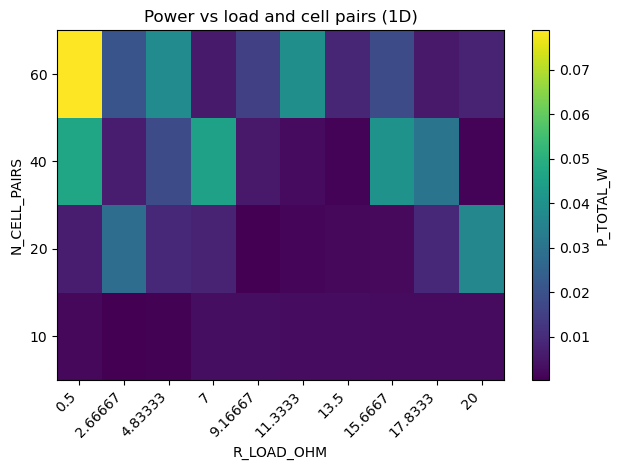

In [8]:
spec = SweepSpec(
    var1="R_LOAD_OHM",
    var1_values=np.linspace(0.5, 20.0, 10),
    var2="N_CELL_PAIRS",
    var2_values=np.array([10, 20, 40, 60], dtype=float),
)

df = run_regime_map(
    fixed_params=base,
    sweep_spec=spec,
    outputs_to_collect=("P_TOTAL_W", "V_TERM_V", "I_TOTAL_A"),
    which="1d",
    mode="fixed_load",
)

print(df.head())
heatmap_from_df(df, x="R_LOAD_OHM", y="N_CELL_PAIRS", z="P_TOTAL_W", title="Power vs load and cell pairs (1D)")


Rows: 324
   A_MEM_M2  N_CELL_PAIRS  P_TOTAL_W  P_DENS_W_M2      regime  converged  \
0    0.0025           5.0   0.000053     0.004245  conducting       True   
1    0.0025           6.0   0.000067     0.004460  conducting       True   
2    0.0025           8.0   0.000093     0.004669  conducting       True   
3    0.0025          10.0   0.000118     0.004704  conducting       True   
4    0.0025          13.0   0.000149     0.004598  conducting       True   

   any_kappa_oob  any_conc_clamped  any_inversion  
0          False             False          False  
1          False             False          False  
2          False             False          False  
3          False             False          False  
4          False             False          False  


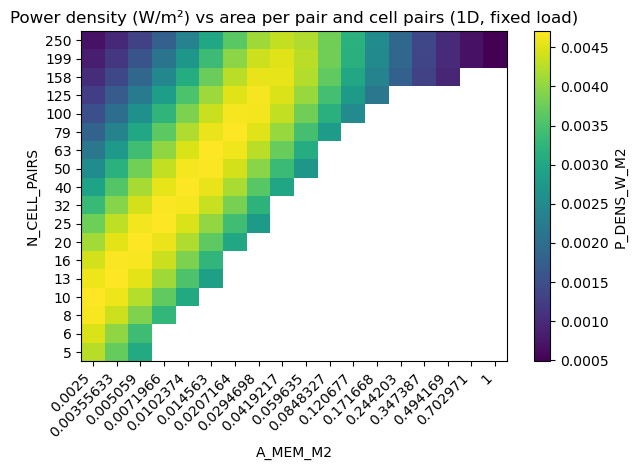

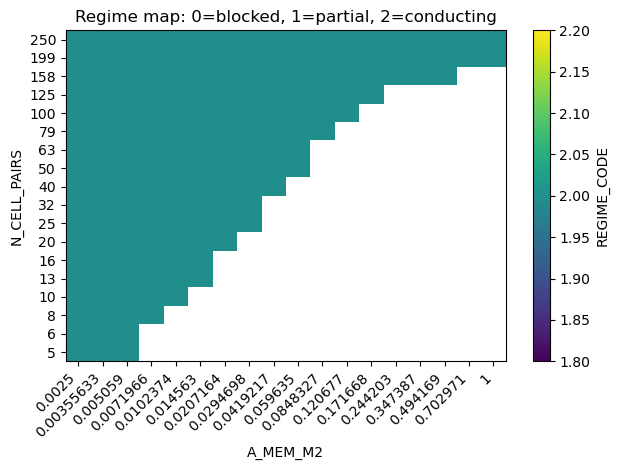

In [9]:
# -------------------------
# Wide-but-structured log sweep (2D): A_MEM_M2 vs N_CELL_PAIRS
# -------------------------

def logspace_int(lo: int, hi: int, n: int) -> np.ndarray:
    vals = np.unique(np.round(np.logspace(np.log10(lo), np.log10(hi), n)).astype(int))
    return vals

def logspace_float(lo: float, hi: float, n: int) -> np.ndarray:
    return np.logspace(np.log10(lo), np.log10(hi), n)

N_vals = logspace_int(5, 250, 18)
A_vals = logspace_float(0.0025, 1.0, 18)

spec_NA = SweepSpec(
    var1="A_MEM_M2",
    var1_values=A_vals,
    var2="N_CELL_PAIRS",
    var2_values=N_vals.astype(float),
)

# Fixed-load sweep to reveal blocked/partial/conducting regimes
baseline_fixed_load = clone_params(base, MODE="fixed_load", R_LOAD_OHM=5.0, N_SEG=30)

df_NA = run_regime_map(
    fixed_params=baseline_fixed_load,
    sweep_spec=spec_NA,
    outputs_to_collect=("P_TOTAL_W", "V_TERM_V", "I_TOTAL_A"),
    which="1d",
    mode="fixed_load",
)

print("Rows:", len(df_NA))
print(df_NA[["A_MEM_M2","N_CELL_PAIRS","P_TOTAL_W","P_DENS_W_M2","regime","converged","any_kappa_oob","any_conc_clamped","any_inversion"]].head())

# Filter to reliable points (adjust filters depending on what you want to visualize)
df_ok = df_NA.copy()
df_ok = df_ok[df_ok["converged"] == True]
df_ok = df_ok[df_ok["any_kappa_oob"] == False]

heatmap_from_df(df_ok, x="A_MEM_M2", y="N_CELL_PAIRS", z="P_DENS_W_M2",
                title="Power density (W/m²) vs area per pair and cell pairs (1D, fixed load)")

heatmap_from_df(df_ok, x="A_MEM_M2", y="N_CELL_PAIRS", z="REGIME_CODE",
                title="Regime map: 0=blocked, 1=partial, 2=conducting")


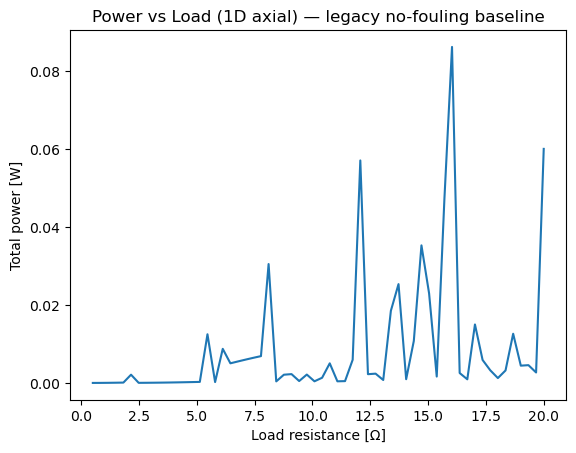

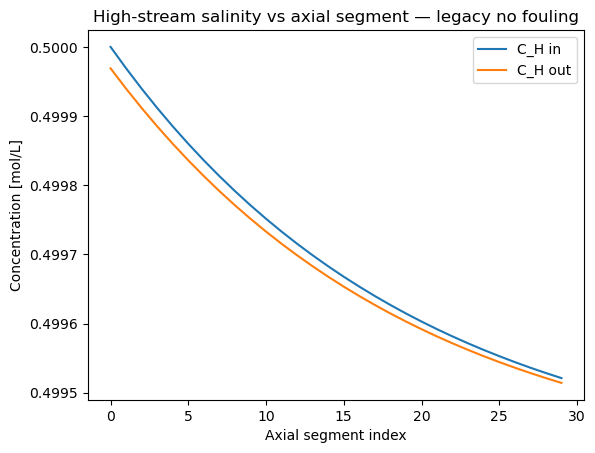

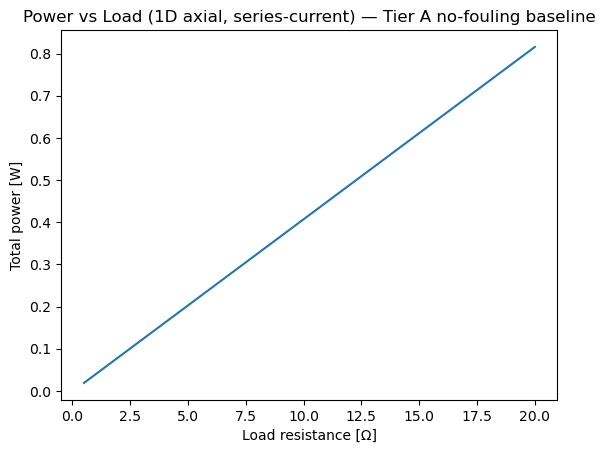

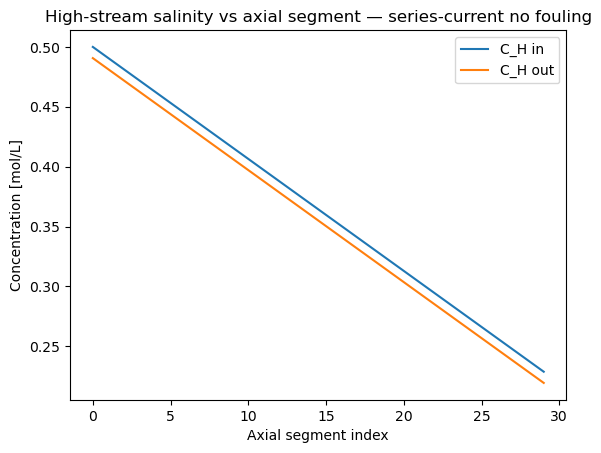

In [10]:
GLOBAL_MODE = "fixed_load"

# -------------------------
# Restored legacy line plots (regression / sanity check)
# -------------------------
# NOTE: This cell intentionally duplicates earlier plots so historical
# visual checks remain available. No prior code or comments were removed.

import matplotlib.pyplot as plt

try:
    base
except NameError:
    base = DesignInputs()

def _with_updates(p: DesignInputs, **kw) -> DesignInputs:
    return replace(p, **kw)

# Power vs load — 1D axial, NO fouling (legacy baseline)
R_loads = np.linspace(0.5, 20.0, 60)
try:
    p_nf = _with_updates(base, FOULING_MODEL='none')
except TypeError:
    # Backward compatibility if DesignInputs in this run doesn't include FOULING_MODEL
    p_nf = base

P_nf = []
for R in R_loads:
    P_nf.append(
        model_1d_axial(_with_updates(p_nf, R_LOAD_OHM=float(R)), mode='fixed_load')['P_TOTAL_W']
    )

plt.figure()
plt.plot(R_loads, P_nf)
plt.title('Power vs Load (1D axial) — legacy no-fouling baseline')
plt.xlabel('Load resistance [Ω]')
plt.ylabel('Total power [W]')
plt.show()

# Axial salinity profile — 1D axial, NO fouling (legacy baseline)
res_nf = model_1d_axial(p_nf, mode='fixed_load')
x = np.arange(int(p_nf.N_SEG), dtype=float)

plt.figure()
plt.plot(x, res_nf['per_segment']['C_H_IN_MOL_L'], label='C_H in')
plt.plot(x, res_nf['per_segment']['C_H_OUT_MOL_L'], label='C_H out')
plt.title('High-stream salinity vs axial segment — legacy no fouling')
plt.xlabel('Axial segment index')
plt.ylabel('Concentration [mol/L]')
plt.legend()
plt.show()


# -------------------------
# NEW: Standard series-current 1D axial plots (single electrode pair)
# -------------------------

# Power vs load — 1D axial series-current, NO fouling (Tier A baseline)
P_sc = []
for R in R_loads:
    P_sc.append(
        model_1d_axial_series_current(_with_updates(p_nf, R_LOAD_OHM=float(R)), mode='fixed_load')['P_TOTAL_W']
    )

plt.figure()
plt.plot(R_loads, P_sc)
plt.title('Power vs Load (1D axial, series-current) — Tier A no-fouling baseline')
plt.xlabel('Load resistance [Ω]')
plt.ylabel('Total power [W]')
plt.show()

# Axial salinity profile — 1D axial series-current, NO fouling (Tier A baseline)
res_sc = model_1d_axial_series_current(p_nf, mode='fixed_load')
x = np.arange(int(p_nf.N_SEG), dtype=float)

plt.figure()
plt.plot(x, res_sc['per_segment']['C_H_IN_MOL_L'], label='C_H in')
plt.plot(x, res_sc['per_segment']['C_H_OUT_MOL_L'], label='C_H out')
plt.title('High-stream salinity vs axial segment — series-current no fouling')
plt.xlabel('Axial segment index')
plt.ylabel('Concentration [mol/L]')
plt.legend()
plt.show()


Reference sweep rows: 40
   R_LOAD_OHM  N_CELL_PAIRS  P_TOTAL_W      regime  converged
0    0.500000          10.0   0.094540  conducting      False
1    0.500000          20.0   0.134783  conducting      False
2    0.500000          40.0   0.216839  conducting       True
3    0.500000          60.0   0.322797  conducting       True
4    2.666667          10.0   0.001653  conducting      False


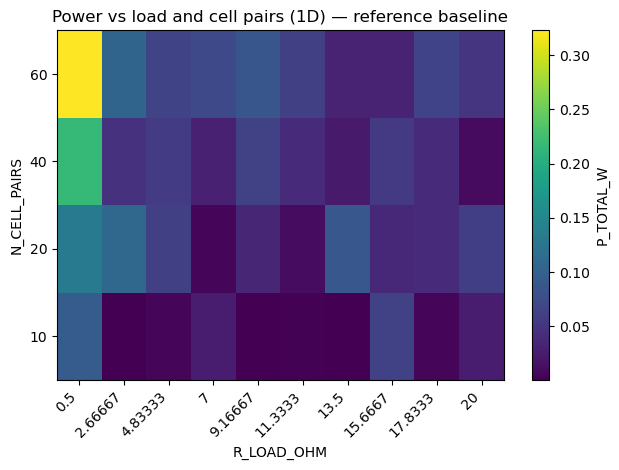

In [11]:
GLOBAL_MODE = "fixed_load"

# -------------------------
# REFERENCE CHECK CELL
# Power vs load and cell pairs (1D) — baseline reproduction
# -------------------------

# This cell is intentionally minimal and mirrors the known-good sweep.
# Purpose: verify that the current code reproduces the historical map exactly.

# Defensive: ensure we have a baseline parameter object
try:
    base_ref = base
except NameError:
    base_ref = DesignInputs()

# Sweep definition (REFERENCE)
spec_ref = SweepSpec(
    var1="R_LOAD_OHM",
    var1_values=np.linspace(0.5, 20.0, 10),
    var2="N_CELL_PAIRS",
    var2_values=np.array([10, 20, 40, 60], dtype=float),
)

# IMPORTANT:
#  - fixed_load mode
#  - 1D model
#  - NO fouling (baseline check)
try:
    base_ref_nf = replace(base_ref, FOULING_MODEL="none")
except TypeError:
    # Backward safety: if FOULING_MODEL is not present for some reason
    base_ref_nf = base_ref

df_ref = run_regime_map(
    fixed_params=base_ref_nf,
    sweep_spec=spec_ref,
    outputs_to_collect=("P_TOTAL_W", "V_TERM_V", "I_TOTAL_A"),
    which="1d",
    mode="fixed_load",
)

print("Reference sweep rows:", len(df_ref))
print(df_ref[["R_LOAD_OHM", "N_CELL_PAIRS", "P_TOTAL_W", "regime", "converged"]].head())

# Reference power heatmap
heatmap_from_df(
    df_ref,
    x="R_LOAD_OHM",
    y="N_CELL_PAIRS",
    z="P_TOTAL_W",
    title="Power vs load and cell pairs (1D) — reference baseline"
)

In [12]:
GLOBAL_MODE = "fixed_load"

# Convention sanity check (non-fatal)
# This cell does NOT change results; it only prints warnings if conventions drift.

try:
    p_chk = base
except NameError:
    p_chk = DesignInputs()

A_stack = p_chk.A_MEM_M2 * p_chk.N_CELL_PAIRS
if A_stack <= 0:
    print('WARNING: Total membrane area is non-positive')

if p_chk.Q_H_M3_S < 1e-8 or p_chk.Q_L_M3_S < 1e-8:
    print('NOTE: Very low stack flow rate — verify units (stack-level m³/s)')

print('Convention check complete.')


Convention check complete.


In [13]:
GLOBAL_MODE = "mppt"

# -------------------------
# Convention sanity checks
# -------------------------
# This is a lightweight check to prevent accidental unit/convention drift.

def print_convention_summary(p: DesignInputs) -> None:
    A_total = float(p.N_CELL_PAIRS) * float(p.A_MEM_M2)
    qh_per_pair = float(p.Q_H_M3_S) / float(max(p.N_CELL_PAIRS, 1))
    ql_per_pair = float(p.Q_L_M3_S) / float(max(p.N_CELL_PAIRS, 1))
    print('A_MEM_M2 interpreted as per-cell-pair area [m^2/cp]')
    print(f'  A_total = N_CELL_PAIRS * A_MEM_M2 = {A_total:.6g} m^2')
    print('Q_H_M3_S, Q_L_M3_S interpreted as TOTAL stack flows [m^3/s]')
    print(f'  Q_H per pair = {qh_per_pair:.6g} m^3/s')
    print(f'  Q_L per pair = {ql_per_pair:.6g} m^3/s')

try:
    print_convention_summary(base)
except NameError:
    print_convention_summary(DesignInputs())


A_MEM_M2 interpreted as per-cell-pair area [m^2/cp]
  A_total = N_CELL_PAIRS * A_MEM_M2 = 10 m^2
Q_H_M3_S, Q_L_M3_S interpreted as TOTAL stack flows [m^3/s]
  Q_H per pair = 5e-07 m^3/s
  Q_L per pair = 5e-07 m^3/s
